## EDA_mk

---

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
from ipyleaflet import *
import time
sns.set()

In [2]:
taxi = pd.read_csv('train.csv')

#### 좌표 묶기, 나누기

In [3]:
taxi['pickup'] = list(zip(taxi['pickup_latitude'], taxi['pickup_longitude']))

In [4]:
taxi['dropoff'] = list(zip(taxi['dropoff_latitude'], taxi['pickup_longitude']))

In [5]:
taxi[['pickup_date', 'pickup_time']] = taxi.pickup_datetime.str.split(expand=True)

In [6]:
taxi[['dropoff_date', 'dropoff_time']] = taxi.dropoff_datetime.str.split(expand=True)

In [7]:
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dropoff,pickup_date,pickup_time,dropoff_date,dropoff_time
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,"(40.7455215454, -73.9822006226)","(40.7401695251, -73.9822006226)",2016-04-08,13:31:04,2016-04-08,13:44:02
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,"(40.747379303, -74.0009460449)","(40.796546936, -74.0009460449)",2016-01-10,07:35:15,2016-01-10,07:46:10
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,"(40.7687988281, -73.9591293335)","(40.7073707581, -73.9591293335)",2016-04-22,06:57:41,2016-04-22,07:10:25
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,"(40.7490615845, -73.9820785522)","(40.757106781, -73.9820785522)",2016-01-05,15:56:26,2016-01-05,16:02:39
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,"(40.7817497253, -73.9795379639)","(40.7905845642, -73.9795379639)",2016-04-05,14:44:25,2016-04-05,14:47:43


---

### dist: direct distance

In [8]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [9]:
taxi['dist'] = \
    haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'],
                 taxi['dropoff_longitude'], taxi['dropoff_latitude'])

In [10]:
taxi['dist'].tail(10)

1458634    5.255687
1458635    0.616594
1458636    0.930065
1458637    3.535334
1458638    2.315993
1458639    1.224311
1458640    6.046037
1458641    7.819693
1458642    1.091878
1458643    1.133330
Name: dist, dtype: float64

## change datetype to calculate

In [11]:
taxi['pickup_datetime'] = taxi['pickup_datetime'].astype('datetime64[ns]')
taxi['dropoff_datetime'] = taxi['dropoff_datetime'].astype('datetime64[ns]')
taxi['s_duration'] = (taxi['dropoff_datetime'] - taxi['pickup_datetime']).astype('timedelta64[ns]')

In [12]:
taxi['s_duration'].tail()

1458639   00:12:58
1458640   00:10:55
1458641   00:12:44
1458642   00:06:13
1458643   00:03:18
Name: s_duration, dtype: timedelta64[ns]

In [13]:
taxi['trip_duration'].tail()

1458639    778
1458640    655
1458641    764
1458642    373
1458643    198
Name: trip_duration, dtype: int64

In [14]:
taxi['s_duration'] = taxi['s_duration'].dt.total_seconds()
taxi['s_duration'].tail()

1458639    778.0
1458640    655.0
1458641    764.0
1458642    373.0
1458643    198.0
Name: s_duration, dtype: float64

In [15]:
taxi['Duration_gap'] = (taxi['s_duration'] - taxi['trip_duration']).abs()
taxi['Duration_gap'].tail()

1458639    0.0
1458640    0.0
1458641    0.0
1458642    0.0
1458643    0.0
Name: Duration_gap, dtype: float64

## check Duration_gap
- between calculated and served

In [16]:
len(taxi['Duration_gap'][taxi['Duration_gap'] > 60])
# expect ) Trip_duration = dropoff time - pickup time

0

In [17]:
print(taxi['Duration_gap'][taxi['Duration_gap'] > 5])
# expect ) Trip_duration = dropoff time - pickup time

Series([], Name: Duration_gap, dtype: float64)


In [18]:
taxi['Duration_gap'].tail()

1458639    0.0
1458640    0.0
1458641    0.0
1458642    0.0
1458643    0.0
Name: Duration_gap, dtype: float64

---

# check outlier

### trip_duration

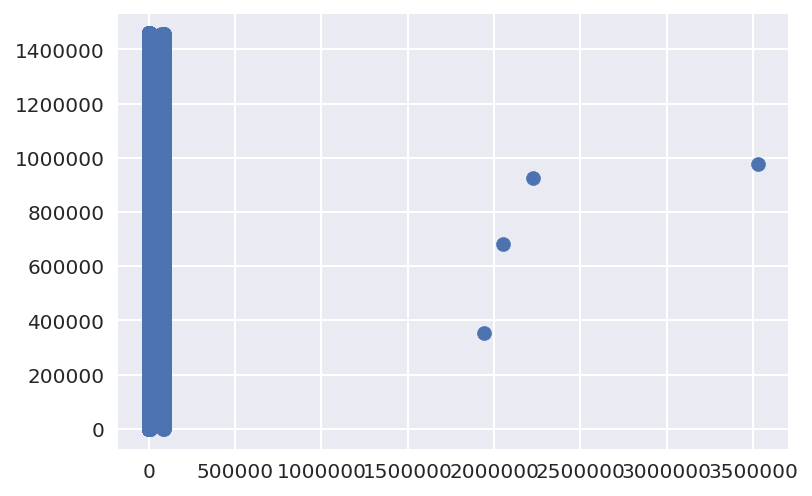

In [19]:
plt.scatter(taxi['trip_duration'], taxi.index)
plt.show() # 4 놈 잡는다.

In [20]:
len(taxi['trip_duration'][taxi['trip_duration'] < 300]) #5분 이하

220485

가설1: 1분 이하 탑승객은 오작동(기계 조작 실수 등)이 아닐까?
- 어느정도의 기간이 적당?
- 1-2: 잘못누른거면 거리의 이동이 없을 수도?

In [21]:
len(taxi['trip_duration'][taxi['trip_duration'] < 60]) #1분 이하

8595

In [22]:
len(taxi['trip_duration'][taxi['trip_duration'] < 10]) # 10초 이하 탑승

1984

---

In [23]:
len(taxi['trip_duration'][taxi['trip_duration'] < 600]) #10분 이하 탑승

651601

In [24]:
less_h = len(taxi['trip_duration'][taxi['trip_duration'] < 3600]) #60분 이하 탑승
less_h

1446310

In [25]:
less_2h= len(taxi['trip_duration'][taxi['trip_duration'] < 7200]) - less_h 
less_2h #60분 이상 120분 이하 탑승

10081

In [26]:
less_3h = len(taxi['trip_duration'][taxi['trip_duration'] < 10800]) - less_2h - less_h
less_3h  #120 - 180분 탑승

141

### got the outlier

In [27]:
more_day= len(taxi['trip_duration'][taxi['trip_duration'] > 86400])
more_day  #24시간 이상 탑승

4

In [28]:
half_day= len(taxi['trip_duration'][taxi['trip_duration'] > 43200]) - more_day
half_day  #12시간 이상 탑승

1989

In [29]:
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dropoff,pickup_date,pickup_time,dropoff_date,dropoff_time,dist,s_duration,Duration_gap
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,"(40.7455215454, -73.9822006226)","(40.7401695251, -73.9822006226)",2016-04-08,13:31:04,2016-04-08,13:44:02,1.224311,778.0,0.0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,"(40.747379303, -74.0009460449)","(40.796546936, -74.0009460449)",2016-01-10,07:35:15,2016-01-10,07:46:10,6.046037,655.0,0.0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,"(40.7687988281, -73.9591293335)","(40.7073707581, -73.9591293335)",2016-04-22,06:57:41,2016-04-22,07:10:25,7.819693,764.0,0.0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,"(40.7490615845, -73.9820785522)","(40.757106781, -73.9820785522)",2016-01-05,15:56:26,2016-01-05,16:02:39,1.091878,373.0,0.0
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,"(40.7817497253, -73.9795379639)","(40.7905845642, -73.9795379639)",2016-04-05,14:44:25,2016-04-05,14:47:43,1.133330,198.0,0.0


In [30]:
taxi = taxi[taxi['trip_duration']<86400].reset_index(drop=True)
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dropoff,pickup_date,pickup_time,dropoff_date,dropoff_time,dist,s_duration,Duration_gap
1458635,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,"(40.7455215454, -73.9822006226)","(40.7401695251, -73.9822006226)",2016-04-08,13:31:04,2016-04-08,13:44:02,1.224311,778.0,0.0
1458636,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,"(40.747379303, -74.0009460449)","(40.796546936, -74.0009460449)",2016-01-10,07:35:15,2016-01-10,07:46:10,6.046037,655.0,0.0
1458637,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,"(40.7687988281, -73.9591293335)","(40.7073707581, -73.9591293335)",2016-04-22,06:57:41,2016-04-22,07:10:25,7.819693,764.0,0.0
1458638,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,"(40.7490615845, -73.9820785522)","(40.757106781, -73.9820785522)",2016-01-05,15:56:26,2016-01-05,16:02:39,1.091878,373.0,0.0
1458639,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,"(40.7817497253, -73.9795379639)","(40.7905845642, -73.9795379639)",2016-04-05,14:44:25,2016-04-05,14:47:43,1.133330,198.0,0.0


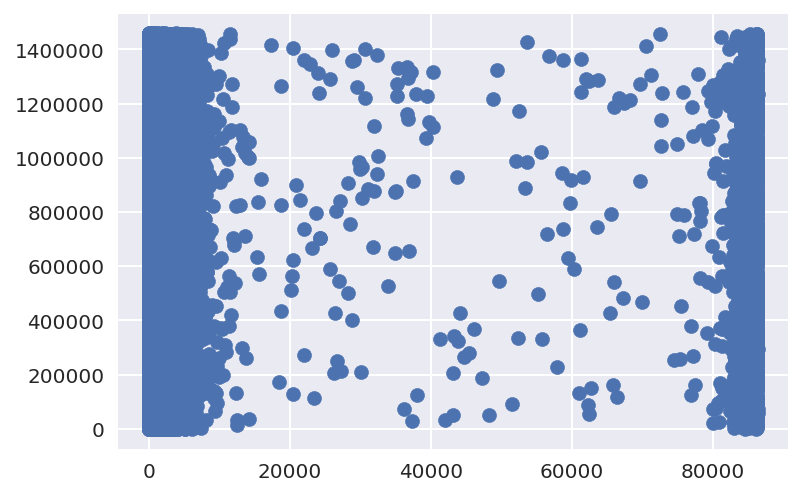

In [31]:
plt.scatter(taxi['trip_duration'], taxi.index)
plt.show()

## distance

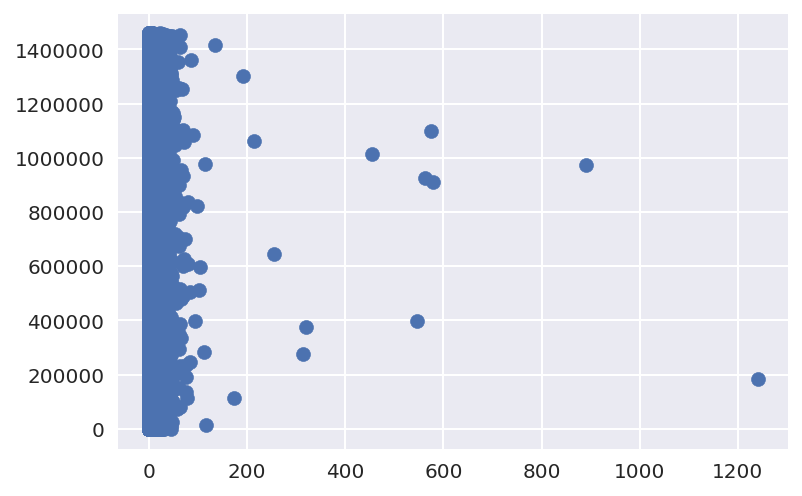

In [32]:
plt.scatter(taxi['dist'], taxi.index)
plt.show() # duration outlier를 제거한 상태, km 단위

In [33]:
taxi[taxi['dist']>800] 
#직선거리 1200 km를 13분만에 이동. 백퍼, 오작동
#직선거리 890km를 11분만에 이동.  상동.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dropoff,pickup_date,pickup_time,dropoff_date,dropoff_time,dist,s_duration,Duration_gap
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.809669,51.881084,-73.987228,40.750599,N,792,"(51.8810844421, -72.8096694946)","(40.7505989075, -72.8096694946)",2016-05-07,18:58:53,2016-05-07,19:12:05,1240.129578,792.0,0.0
974375,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.799896,35.081532,-79.352837,40.436329,N,611,"(35.0815315247, -71.7998962402)","(40.4363288879, -71.7998962402)",2016-01-06,20:40:52,2016-01-06,20:51:03,890.654559,611.0,0.0


In [34]:
len(taxi['dist'][taxi['dist'] < 0.1])  #100m 이하 

13319

In [35]:
len(taxi['dist'][taxi['dist'] < 0.01])  #10m 이하 

8665

In [36]:
len(taxi['dist'][taxi['dist'] < 0.001])  #1m 이하 

6549

In [37]:
len(taxi['dist'][taxi['dist'] < 0.0001])  #10cm 이하 

5897

In [38]:
len(taxi['dist'][taxi['dist'] < 0.00001])  #1cm 이하 이동

5897

---

leaflet

In [39]:
center = [40.745522, -73.982201] #lati, longi
zoom = 13
m = Map(center=center, zoom=zoom)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[40.745522, -73.982201], default_tiles=TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']), layers=(TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']),), layout=Layout(align_self='stretch', height='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=13)

In [40]:
marker = Marker(location=center)
m += marker

In [41]:
for loc in locs:
    marker = Marker(location=loc)
    m += marker
    time.sleep(0.5)

NameError: name 'locs' is not defined

In [42]:
dc = DrawControl(circle={'shapeOptions':{'color':'#0000FF'}}, rectangle={'shapeOptions':{'color':'#0000FF'}})
m.add_control(dc)